# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [2]:
# Package Imports

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
import time
import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


2024-07-26 13:31:04.994653: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 13:31:05.027442: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 13:31:05.027471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 13:31:05.027490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 13:31:05.034688: I tensorflow/core/platform/cpu_feature_g

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Data Loading

# load Oxford Flowers 102 Dataset
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# Data Splits

# split data
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# I've experimented a bit with the set
#train_and_val = dataset['train'].concatenate(dataset['validation'])
#test = dataset['test']

# new splitting: 6149 Training, 1020 Validation, 1020 Test
#new_train = test.take(6149)
#new_val = dataset['validation']
#new_test = dataset['train']

#print(f"New Training set size: {len(list(new_train))}")
#print(f"New Validation set size: {len(list(new_val))}")
#print(f"New Test set size: {len(list(new_test))}")


2024-07-26 13:31:09.307233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 13:31:09.310896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 13:31:09.310933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 13:31:09.314723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 13:31:09.314764: I tensorflow/compile

## Explore the Dataset

In [4]:
# Dataset Info

# TODO: Get the number of examples in each set from the dataset info.
print(f"Training set size: {info.splits['train'].num_examples}")
print(f"Validation set size: {info.splits['validation'].num_examples}")
print(f"Test set size: {info.splits['test'].num_examples}")

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = info.features['label'].num_classes
print(f"Number of classes: {num_classes}")


Training set size: 1020
Validation set size: 1020
Test set size: 6149
Number of classes: 102


In [5]:
# Dataset Images
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in train_dataset.take(3):
    print(f"Image shape: {image.shape}, Label: {label}")

Image shape: (500, 667, 3), Label: 72
Image shape: (500, 666, 3), Label: 84
Image shape: (670, 500, 3), Label: 70


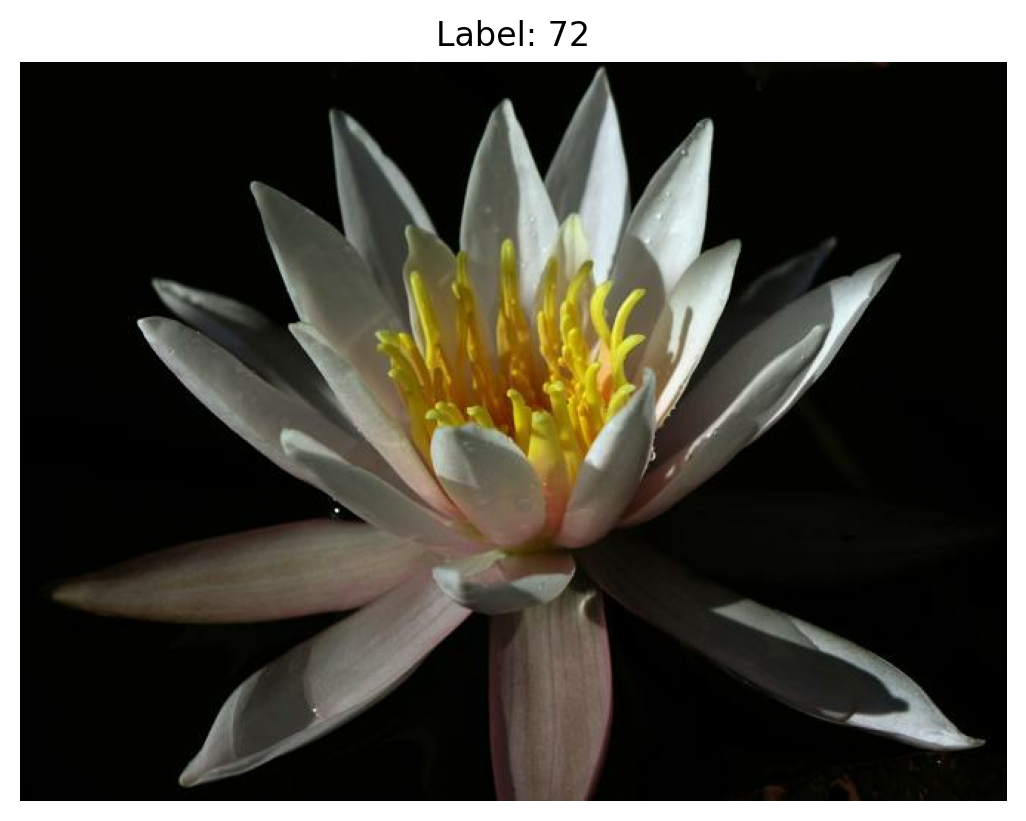

In [6]:
# Plot Image
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in dataset['train'].take(1):
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")  # Klassenname aus der JSON-Datei verwenden
    plt.axis('off')
    plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [7]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

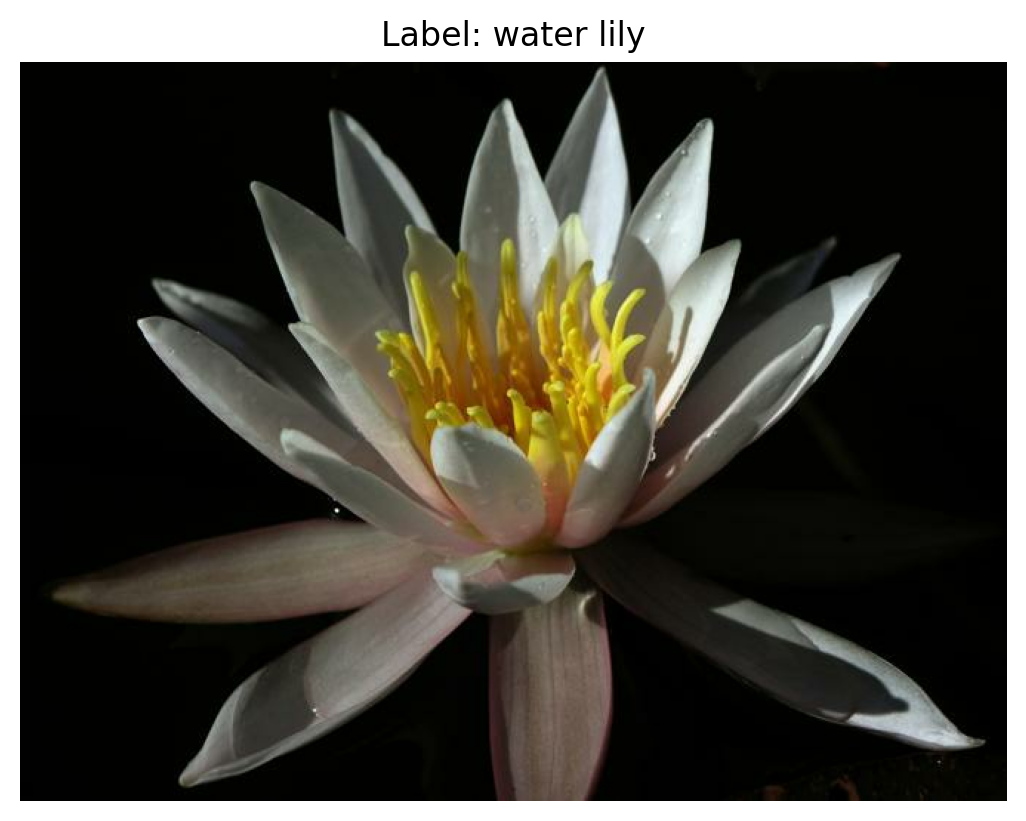

In [8]:
# Label Mapping

# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in dataset['train'].take(1):
    plt.imshow(image.numpy())
    plt.title(f"Label: {class_names[str(label.numpy())]}")  # Klassenname aus der JSON-Datei verwenden
    plt.axis('off')
    plt.show()


## Create Pipeline

In [9]:
# Data Pipeline

# TODO: Create a pipeline for each set.
batch_size = 32

# image preprocess
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) 
    image = image / 255.0  # Data Normalization
    
    return image, label
    
def augment(image, label):
    image = tf.image.resize(image, (256, 256))
    image = tf.image.central_crop(image, central_fraction=0.875)
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.cast(image, tf.float32) / 255.0  # Data Normalization
    
    return image, label

# Data Pipeline, Data Batching
# prepare data (augmenting, preprocessing and batching)
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [11]:
# Pre-trained Network
# TODO: Build and train your network.
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(mobilenet_url, input_shape=(224, 224, 3), trainable=False)

# Feedforward Classifier
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)) # try out a L2 regularization with a lambda of 0.01
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the Network
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=20,
                    callbacks=[early_stopping])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/20
32/32 [==============================] - 5s 76ms/step - loss: 6.3088 - accuracy: 0.0569 - val_loss: 5.1288 - val_accuracy: 0.2441
Epoch 2/20
32/32 [==============================] - 2s 58ms/step - loss: 4.5582 - accuracy: 0.3118 - val_loss: 4.1114 - val_accuracy: 

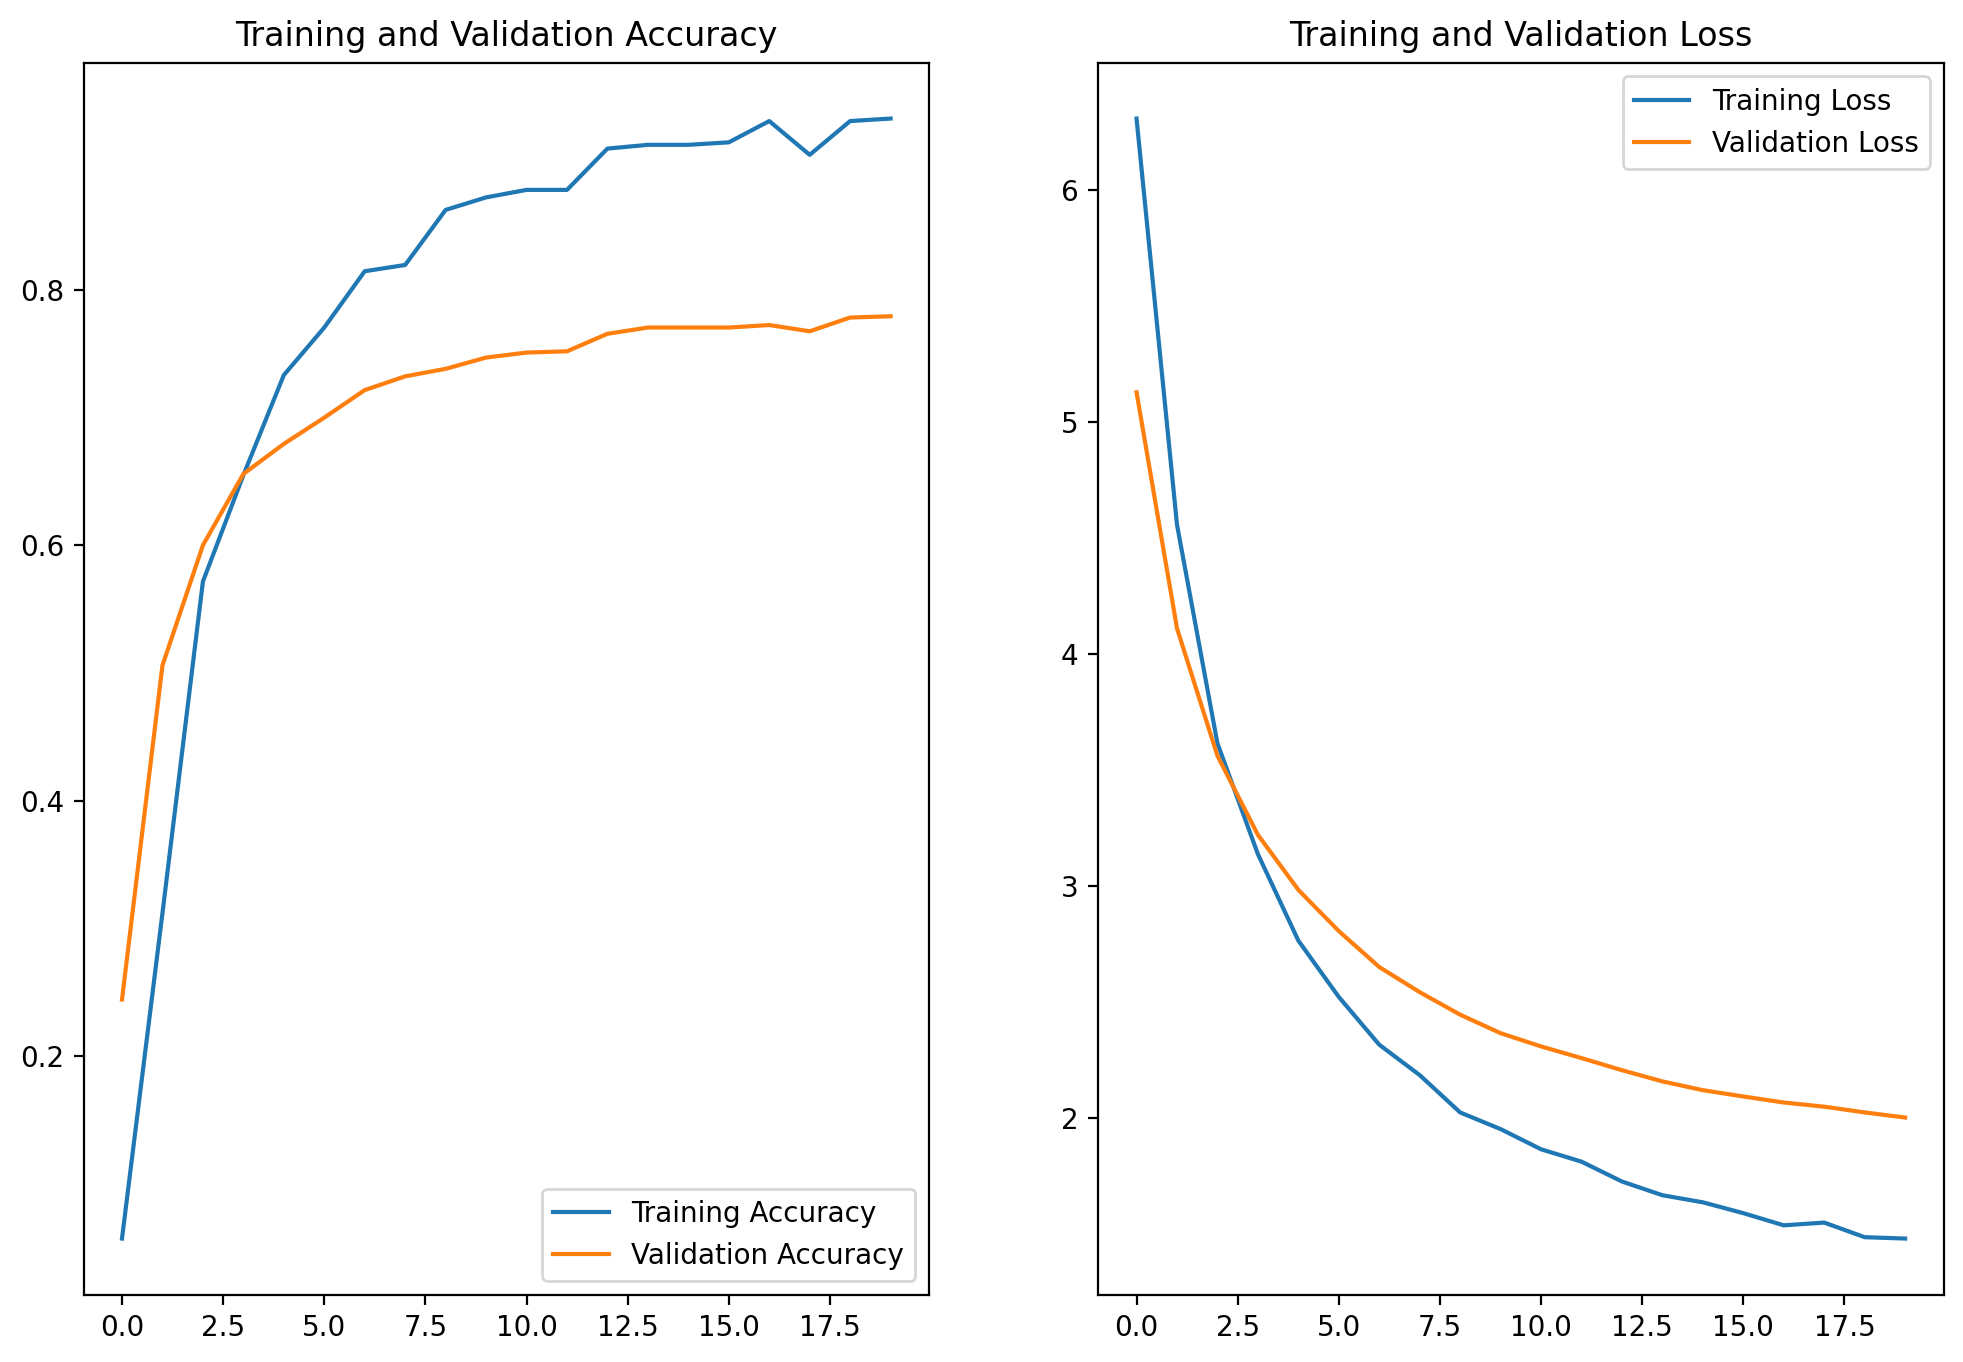

In [12]:
# Validation Loss and Accuracy
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# plot accuracy
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
# Testing Accuracy
loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy}")


193/193 [==============================] - 6s 28ms/step - loss: 2.0831 - accuracy: 0.7561
Test accuracy: 0.7560579180717468


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [14]:
# Saving the Model
# TODO: Save your trained model as a Keras model.
model.save('saved_model')


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


## Load the Keras Model

Load the Keras model you saved above.

In [95]:
# Loading Model
# TODO: Load the Keras model
model = tf.keras.models.load_model('saved_model', custom_objects={'KerasLayer': hub.KerasLayer})
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_15 (KerasLayer  (None, 1280)              2257984   
 )                                                               
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [15]:
# Image Processing
# TODO: Create the process_image function
# Image Processing
def process_image(image_path):
    '''Scales, crops, and normalizes a PIL image,
       returns a TensorFlow tensor
    '''
    image = Image.open(image_path)

    # Scale the image to shortest side and keep aspect ratio
    aspect_ratio = image.width / image.height
    if aspect_ratio > 1:        
        new_size = (int(aspect_ratio * 256), 256)
    else:        
        new_size = (256, int(256 / aspect_ratio))
    
    image = image.resize(new_size)

    # Crop around the center
    width, height = image.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = left + 224
    bottom = top + 224
    
    image = image.crop((left, top, right, bottom))

    # Convert to numpy array
    np_image = np.array(image)

    # Normalize to 0-1
    np_image = np_image / 255.0

    # TensorFlow expects images in the format (height, width, channels)
    # So no need to transpose like PyTorch

    # Convert to TensorFlow tensor
    tf_image = tf.convert_to_tensor(np_image, dtype=tf.float32)

    return tf_image


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

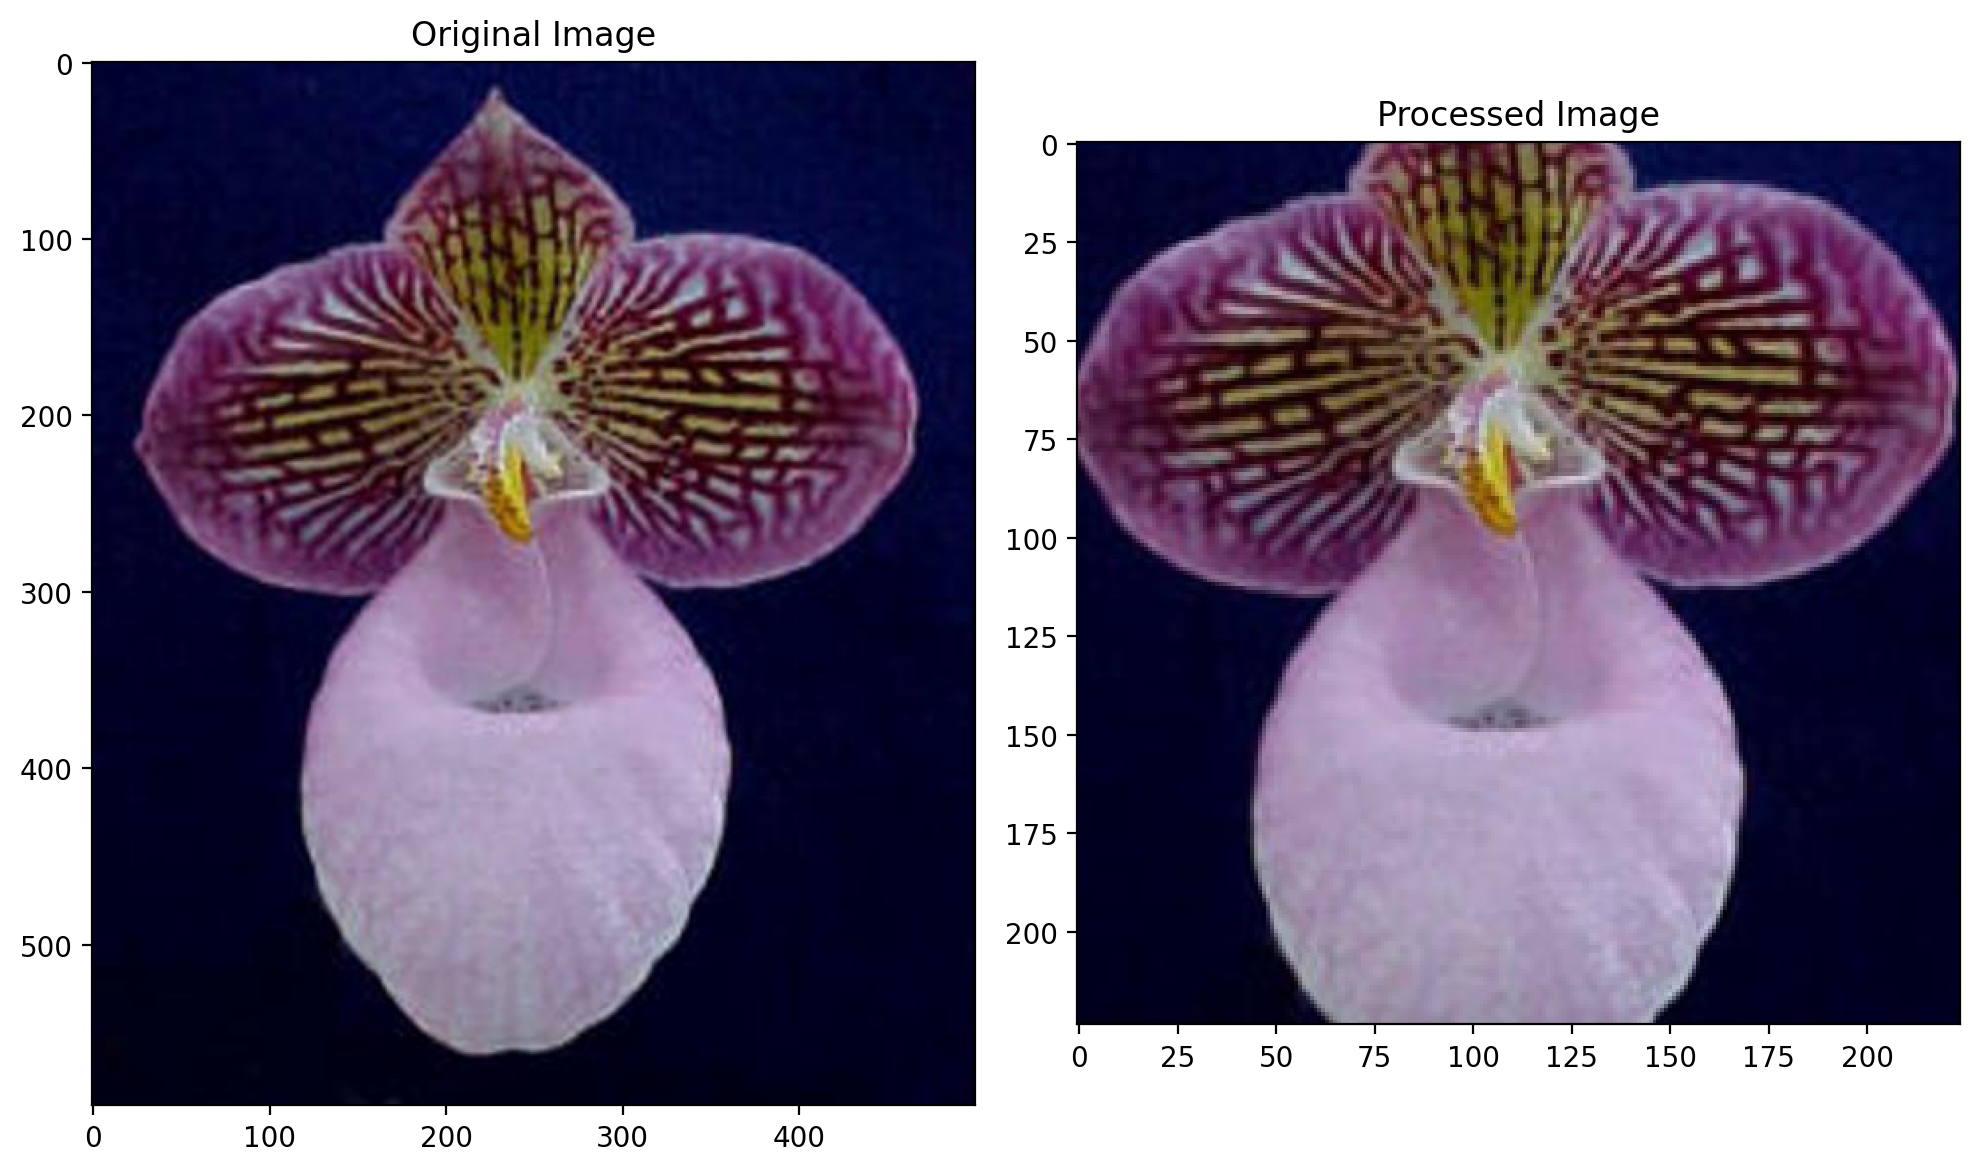

In [16]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(image_path)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [17]:
# Inference
# TODO: Create the predict function
# info.features['label'] and class_names

# Class Prediction
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''   
    # process image
    loaded_img = process_image(image_path)
    
    # extend image with a batch dimension, so the net can work with it
    loaded_img = tf.expand_dims(loaded_img, axis=0)
    
    # model must be in the prediction mode
    model.trainable = False

    output = model(loaded_img)
    
    # top-k probabilities
    top_probs, top_indices = tf.nn.top_k(output, k=topk)
        
    # we use the named labes from the orginal oxford flower set
    labels = info.features['label'].names
    classes = [labels[idx] for idx in top_indices[0].numpy()]

    return top_probs[0].numpy(), classes 


In [18]:
# Class Prediction
probs, classes = predict('./test_images/hard-leaved_pocket_orchid.jpg', model)
print(probs)
print(classes)

[0.96367425 0.00485838 0.00401793 0.00365743 0.00333372]
['hard-leaved pocket orchid', 'anthurium', 'wild pansy', 'spring crocus', 'giant white arum lily']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [19]:
# Sanity Check
# TODO: Plot the input image along with the top 5 classes
def view_classify(image, ps, classes):
    ''' Function for viewing an image and its predicted classes.
    '''
    ps = ps.numpy().squeeze()

    # TensorFlow tensors assume the color channel is the last dimension
    # Undo preprocessing (revert to denormalized values)    
    image = image.numpy()

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(image)
    ax1.axis('off')

    y_pos = np.arange(len(classes))
    ax2.barh(y_pos, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes, size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

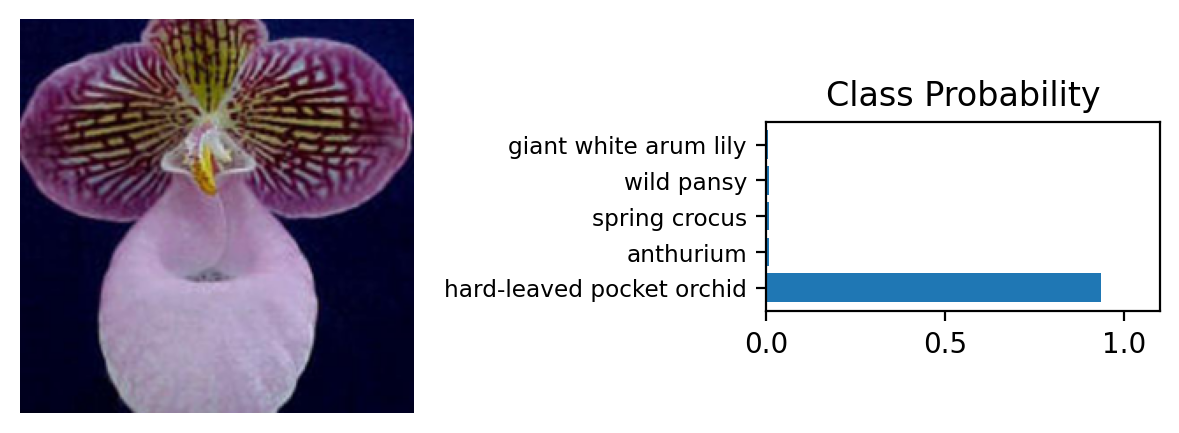

In [141]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'

info = info   # Hier die info-Variable von tfds.load() einfügen
class_names = info.features['label']  # Hier das Dict mit Original-Labels zu Namen einfügen

# Verarbeite das Bild und mache eine Vorhersage
processed_image = process_image(image_path)
probs, classes = predict(image_path, model)

# Zeige das Bild und die Vorhersagen an
view_classify(processed_image, tf.convert_to_tensor(probs), classes)